#  Feature Engineering

In [17]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
from data import AntiFraudData
from gradientDescent import *
from confusionMetrics import *
import matplotlib.pyplot as plt
from featureProcess import *
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from scipy import interp

### load data, split into training and testing dataset

In [50]:
data_path = 'D:\\Codes\\Python\\FraudDetectProject\\data\\anti_fraud_data.csv'
raw_data = AntiFraudData(data_path)._raw
train_data, test_data = model_selection.train_test_split(raw_data, test_size=0.3)

### check overall fraud percentage

In [51]:
print('overall fraud rate is {0:2.4f}%'.format(train_data['flag'].mean()*100))

overall fraud rate is 1.1282%


In [52]:
feature_process = BasicFeatureProcess()
# check constant variable
fixed_cols = feature_process.fix_value_check(train_data)
if fixed_cols:
    print('Constant columns:', fixed_cols)
    train_data = train_data.drop(fixed_cols, axis=1).copy()
else:
    print('No constant columns')

Constant columns: ['ip_desc_danger']


### check features' missing percentage


 age ==0 indicates a missing value

Text(0.5, 1.0, 'Columns Missing Rate')

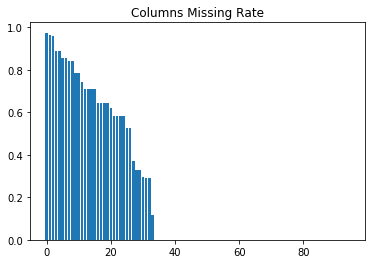

In [53]:
train_data.loc[train_data.age==0, 'age'] = np.nan
missing_rate_df = feature_process.missing_value_pct(train_data)
plt.bar(x=range(missing_rate_df.shape[0]), height=missing_rate_df['missing_rate'])
plt.title('Columns Missing Rate')

In [54]:
columns_with_missing = missing_rate_df.index[missing_rate_df.missing_rate>0].tolist()

### add missing indicator

In [56]:
train_data = feature_process.add_missing_indicator_to_df(data=train_data, cols=columns_with_missing)

In [57]:
missing_odds_ratio = feature_process.missing_odds_ratio(train_data, cols=columns_with_missing, flag_col='flag')

Text(0.5, 1.0, 'missing value odds ratio')

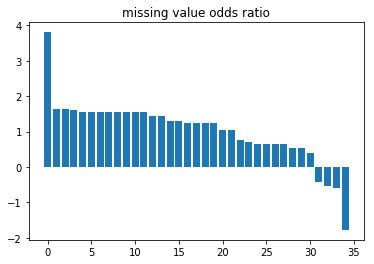

In [58]:
plt.bar(x=range(missing_odds_ratio.shape[0]), height=missing_odds_ratio.odds_ratio)
plt.title('missing value odds ratio')

### categorical feature

In [59]:
obj_types = feature_process.feature_type_identifier(train_data, 'O')
obj_types

['registered_channels', 'area11_danger', 'area6_danger']

In [60]:
data_counts = train_data.nunique() 
categorical_cols = data_counts.index[data_counts<=10].tolist()
categorical_cols = list(set(categorical_cols+obj_types) - set(['flag']))

 for categorical feature with missing value encode with dummy variable and delete original ferature

In [61]:
categoriacal_cols_with_missing = list(set(columns_with_missing) & set(categorical_cols))

In [62]:
dummy_result = feature_process.get_categorical_dummy_variable(train_data, categorical_cols)
train_data = dummy_result['data']
dummy_columns = dummy_result['dummy_cols']

continous variable fill missing value as 0, and using missing indicator 

In [63]:
continues_col_with_missing = list(set(columns_with_missing)-set(categoriacal_cols_with_missing))
train_data[continues_col_with_missing] = train_data[continues_col_with_missing].fillna(0)

### feature derivative

average payment during periods

In [64]:
feature_derive = FeatureDerivative()
train_data = feature_derive.avg_payment_derivative(train_data)

### outlier detection & normalization

In [65]:
all_columns = list(train_data.columns)
all_columns.remove('ID')
all_columns.remove('flag')
numerical_columns = list(set(all_columns) - set(dummy_columns) - set(categorical_cols))
outlier_columns = get_outlier_features(train_data, numerical_columns, expand=True)

In [66]:
outlier_fraud_df = outlier_effect(train_data, outlier_cols=outlier_columns, flag_col='flag', expand=True)

D:\Codes\Python\FraudDetectProject\featureProcess\FeatureStandard.py:70: RuntimeWarning: divide by zero encountered in log
  lower_log_odds, upper_log_odds = np.log(l), np.log(u)


In [67]:
# no significant difference 
# feature standarlization
lower, upper, mu, sigma = {}, {}, {}, {}
for col in outlier_columns:
    temp_df = train_data[[col,'flag']]
    zero_score = zero_score_normalization(temp_df,col)
    if zero_score ==1:
        del train_data[col]
        outlier_columns.remove(col)
        numerical_columns.remove(col)
        continue
    train_data[col] = zero_score['new_var']
    lower[col], upper[col], mu[col], sigma[col] =zero_score['lower'], zero_score['upper'], zero_score['mu'], zero_score['sigma']

In [68]:
training_data_clean = 'D:\\Codes\\Python\\FraudDetectProject\\data\\training_data_clean.csv'
train_data.to_csv(training_data_clean, index=False)

### do the same feature Engineering for testing data

In [69]:
print('overall fraud rate is {0:2.4f}%'.format(test_data['flag'].mean()*100))
test_data = test_data.drop(fixed_cols, axis=1).copy()
test_data.loc[test_data.age==0, 'age'] = np.nan

overall fraud rate is 1.0643%


In [70]:
test_data = feature_process.add_missing_indicator_to_df(data=test_data, cols=columns_with_missing)

In [71]:
dummy_result = feature_process.get_categorical_dummy_variable(test_data, categorical_cols)
test_data = dummy_result['data']
test_data[continues_col_with_missing] = test_data[continues_col_with_missing].fillna(0)

In [72]:
test_data = feature_derive.avg_payment_derivative(test_data)
# outlier_columns = get_outlier_features(test_data, all_columns)
# lower, upper, mu, sigma = {}, {}, {}, {}
for col in outlier_columns:
    temp_df = test_data[[col,'flag']]
    if col not in numerical_columns:
        del test_data[col]
        continue
    test_data[col] = (temp_df[col] - mu[col])/sigma[col]

In [73]:
testing_data_clean = 'D:\\Codes\\Python\\FraudDetectProject\\data\\testing_data_clean.csv'
test_data.to_csv(testing_data_clean, index=False)